In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import libraries
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Set the path to the dataset in Google Drive
dataset_path = '/content/drive/MyDrive/Challenge dataset new/Challenge dataset new'

# Define transformations to resize and convert images to grayscale
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure single-channel for grayscale
    transforms.Resize((28, 28)),  # Resize to match input size expected by Prototypical Networks
    transforms.ToTensor()
])

# Load dataset with ImageFolder, which expects each folder as a separate class
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Function to create support and query loaders
def get_dataloaders(dataset, n_way, n_shot, n_query):
    support_indices, query_indices = [], []
    class_to_indices = {cls: torch.where(torch.tensor(dataset.targets) == cls)[0] for cls in range(len(dataset.classes))}

    for cls_indices in class_to_indices.values():
        cls_indices = cls_indices[torch.randperm(len(cls_indices))]
        support_indices += cls_indices[:n_shot].tolist()
        query_indices += cls_indices[n_shot:n_shot + n_query].tolist()

    support_loader = DataLoader(torch.utils.data.Subset(dataset, support_indices), batch_size=n_way * n_shot, shuffle=False)
    query_loader = DataLoader(torch.utils.data.Subset(dataset, query_indices), batch_size=n_way * n_query, shuffle=False)

    return support_loader, query_loader

# Define Prototypical Network
class PrototypicalNetwork(nn.Module):
    def __init__(self, x_dim=1, hid_dim=64, z_dim=64):
        super(PrototypicalNetwork, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(x_dim, hid_dim, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(hid_dim, hid_dim, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(hid_dim, z_dim, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(z_dim, z_dim, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        return self.encoder(x).view(x.size(0), -1)

# Define function to compute prototypical loss
def prototypical_loss(model, support_loader, query_loader, n_way, n_shot):
    # Get support embeddings and compute prototypes
    support_data, support_labels = next(iter(support_loader))
    support_data = support_data.cuda()
    support_embeddings = model(support_data)
    prototypes = support_embeddings.view(n_way, n_shot, -1).mean(dim=1)

    # Get query embeddings
    query_data, query_labels = next(iter(query_loader))
    query_data = query_data.cuda()
    query_embeddings = model(query_data)

    # Compute distances and loss
    distances = torch.cdist(query_embeddings, prototypes)
    log_p_y = -distances
    labels = torch.arange(n_way).unsqueeze(1).repeat(1, n_query).flatten().cuda()
    loss = nn.CrossEntropyLoss()(log_p_y, labels)

    _, predicted = log_p_y.max(1)
    accuracy = (predicted == labels).float().mean().item()

    return loss, accuracy

# Hyperparameters
n_way = 5    # Number of classes per episode
n_shot = 5   # Number of support examples per class
n_query = 15 # Number of query examples per class
learning_rate = 0.001
n_epochs = 100

# Initialize model, optimizer, and move model to GPU if available
model = PrototypicalNetwork().cuda()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(n_epochs):
    support_loader, query_loader = get_dataloaders(dataset, n_way, n_shot, n_query)
    model.train()

    # Compute prototypical loss and accuracy
    loss, accuracy = prototypical_loss(model, support_loader, query_loader, n_way, n_shot)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item()}, Accuracy: {accuracy*100:.2f}%")


Epoch 1/100, Loss: 1.5964611768722534, Accuracy: 68.00%
Epoch 2/100, Loss: 1.569677472114563, Accuracy: 68.00%
Epoch 3/100, Loss: 1.5216916799545288, Accuracy: 65.33%
Epoch 4/100, Loss: 1.440161943435669, Accuracy: 73.33%
Epoch 5/100, Loss: 1.3873060941696167, Accuracy: 69.33%
Epoch 6/100, Loss: 1.276983380317688, Accuracy: 54.67%
Epoch 7/100, Loss: 1.1607987880706787, Accuracy: 62.67%
Epoch 8/100, Loss: 0.9609948992729187, Accuracy: 66.67%
Epoch 9/100, Loss: 1.0647470951080322, Accuracy: 50.67%
Epoch 10/100, Loss: 0.9996307492256165, Accuracy: 60.00%
Epoch 11/100, Loss: 1.2049883604049683, Accuracy: 52.00%
Epoch 12/100, Loss: 0.7116881608963013, Accuracy: 70.67%
Epoch 13/100, Loss: 0.8577682375907898, Accuracy: 60.00%
Epoch 14/100, Loss: 0.891348659992218, Accuracy: 65.33%
Epoch 15/100, Loss: 0.853067934513092, Accuracy: 64.00%
Epoch 16/100, Loss: 0.6363865733146667, Accuracy: 80.00%
Epoch 17/100, Loss: 0.6896495819091797, Accuracy: 77.33%
Epoch 18/100, Loss: 0.5077798366546631, Accur

In [3]:
# Save the trained model
torch.save(model.state_dict(), '/content/drive/MyDrive/archaeological_prototypical_network.pth')

# To load the model later:
model = PrototypicalNetwork().cuda()
model.load_state_dict(torch.load('/content/drive/MyDrive/archaeological_prototypical_network.pth'))


<ipython-input-3-d79f2ddb6563>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/archaeological_prototypical_network.

<All keys matched successfully>

In [5]:
def evaluate_model(model, dataset, n_way, n_shot, n_query):
    support_loader, query_loader = get_dataloaders(dataset, n_way, n_shot, n_query)
    model.eval()  # Set to evaluation mode

    # Compute loss and accuracy
    with torch.no_grad():  # No gradients needed for evaluation
        loss, accuracy = prototypical_loss(model, support_loader, query_loader, n_way, n_shot)

    print(f"Test Loss: {loss.item()}, Test Accuracy: {accuracy*100:.2f}%")
    return accuracy

# Example usage on the test dataset
test_accuracy = evaluate_model(model, dataset, n_way=5, n_shot=5, n_query=15)


Test Loss: 0.07087767124176025, Test Accuracy: 97.33%


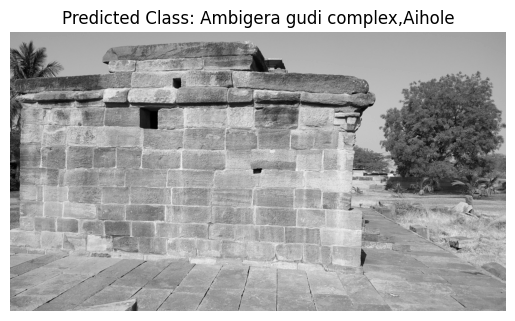

In [6]:
from PIL import Image
import matplotlib.pyplot as plt

def show_classified_image(model, support_loader, image_path, n_way, n_shot):
    # Load and transform the new image
    image = Image.open(image_path).convert('L')  # Convert to grayscale if required
    image_tensor = transform(image).unsqueeze(0).cuda()  # Add batch dimension and move to GPU

    # Get embeddings of support images and compute prototypes
    support_data, support_labels = next(iter(support_loader))
    support_data = support_data.cuda()
    support_embeddings = model(support_data)
    prototypes = support_embeddings.view(n_way, n_shot, -1).mean(dim=1)

    # Get embedding of query image (new image)
    query_embedding = model(image_tensor)

    # Compute distances to prototypes
    distances = torch.cdist(query_embedding, prototypes)
    _, predicted_label = torch.min(distances, dim=1)

    # Map label index back to class name
    predicted_class = dataset.classes[predicted_label.item()]

    # Display the image with its predicted class label
    plt.imshow(image, cmap='gray')
    plt.title(f"Predicted Class: {predicted_class}")
    plt.axis('off')
    plt.show()

# Example usage for a new image
image_path = '/content/drive/MyDrive/Challenge dataset new/Challenge dataset new/Ambigera gudi complex,Aihole/IMG_20190316_090931.jpgresize.jpg'  # Replace with the actual path to your image
show_classified_image(model, support_loader, image_path, n_way=5, n_shot=5)

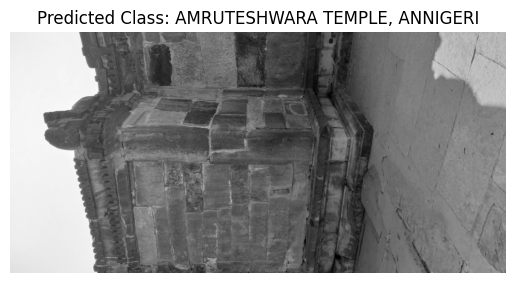

In [7]:
from PIL import Image
import matplotlib.pyplot as plt

def show_classified_image(model, support_loader, image_path, n_way, n_shot):
    # Load and transform the new image
    image = Image.open(image_path).convert('L')  # Convert to grayscale if required
    image_tensor = transform(image).unsqueeze(0).cuda()  # Add batch dimension and move to GPU

    # Get embeddings of support images and compute prototypes
    support_data, support_labels = next(iter(support_loader))
    support_data = support_data.cuda()
    support_embeddings = model(support_data)
    prototypes = support_embeddings.view(n_way, n_shot, -1).mean(dim=1)

    # Get embedding of query image (new image)
    query_embedding = model(image_tensor)

    # Compute distances to prototypes
    distances = torch.cdist(query_embedding, prototypes)
    _, predicted_label = torch.min(distances, dim=1)

    # Map label index back to class name
    predicted_class = dataset.classes[predicted_label.item()]

    # Display the image with its predicted class label
    plt.imshow(image, cmap='gray')
    plt.title(f"Predicted Class: {predicted_class}")
    plt.axis('off')
    plt.show()

# Example usage for a new image
image_path = '/content/drive/MyDrive/Challenge dataset new/Challenge dataset new/AMRUTESHWARA TEMPLE, ANNIGERI/20190316_145842.jpgresize.jpg'  # Replace with the actual path to your image
show_classified_image(model, support_loader, image_path, n_way=5, n_shot=5)

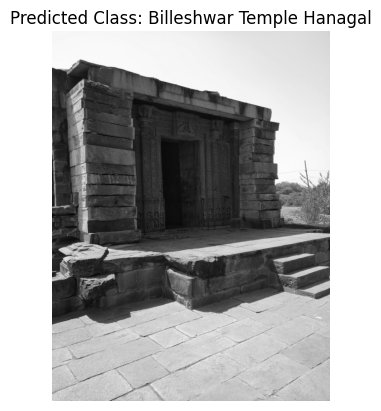

In [8]:
from PIL import Image
import matplotlib.pyplot as plt

def show_classified_image(model, support_loader, image_path, n_way, n_shot):
    # Load and transform the new image
    image = Image.open(image_path).convert('L')  # Convert to grayscale if required
    image_tensor = transform(image).unsqueeze(0).cuda()  # Add batch dimension and move to GPU

    # Get embeddings of support images and compute prototypes
    support_data, support_labels = next(iter(support_loader))
    support_data = support_data.cuda()
    support_embeddings = model(support_data)
    prototypes = support_embeddings.view(n_way, n_shot, -1).mean(dim=1)

    # Get embedding of query image (new image)
    query_embedding = model(image_tensor)

    # Compute distances to prototypes
    distances = torch.cdist(query_embedding, prototypes)
    _, predicted_label = torch.min(distances, dim=1)

    # Map label index back to class name
    predicted_class = dataset.classes[predicted_label.item()]

    # Display the image with its predicted class label
    plt.imshow(image, cmap='gray')
    plt.title(f"Predicted Class: {predicted_class}")
    plt.axis('off')
    plt.show()

# Example usage for a new image
image_path = '/content/drive/MyDrive/Challenge dataset new/Challenge dataset new/Billeshwar Temple Hanagal/102.jpgresize.jpg'  # Replace with the actual path to your image
show_classified_image(model, support_loader, image_path, n_way=5, n_shot=5)

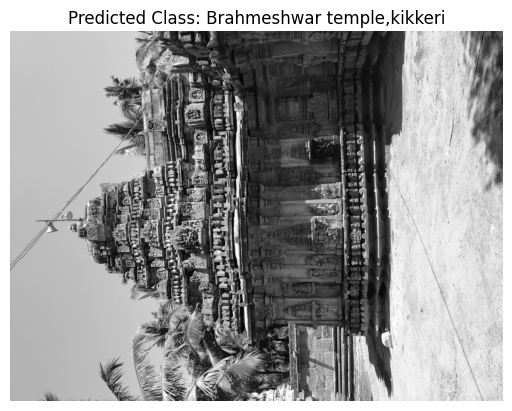

In [9]:
from PIL import Image
import matplotlib.pyplot as plt

def show_classified_image(model, support_loader, image_path, n_way, n_shot):
    # Load and transform the new image
    image = Image.open(image_path).convert('L')  # Convert to grayscale if required
    image_tensor = transform(image).unsqueeze(0).cuda()  # Add batch dimension and move to GPU

    # Get embeddings of support images and compute prototypes
    support_data, support_labels = next(iter(support_loader))
    support_data = support_data.cuda()
    support_embeddings = model(support_data)
    prototypes = support_embeddings.view(n_way, n_shot, -1).mean(dim=1)

    # Get embedding of query image (new image)
    query_embedding = model(image_tensor)

    # Compute distances to prototypes
    distances = torch.cdist(query_embedding, prototypes)
    _, predicted_label = torch.min(distances, dim=1)

    # Map label index back to class name
    predicted_class = dataset.classes[predicted_label.item()]

    # Display the image with its predicted class label
    plt.imshow(image, cmap='gray')
    plt.title(f"Predicted Class: {predicted_class}")
    plt.axis('off')
    plt.show()

# Example usage for a new image
image_path = '/content/drive/MyDrive/Challenge dataset new/Challenge dataset new/Brahmeshwar temple,kikkeri/IMG_20190316_110914 (1).jpgresize.jpg'  # Replace with the actual path to your image
show_classified_image(model, support_loader, image_path, n_way=5, n_shot=5)

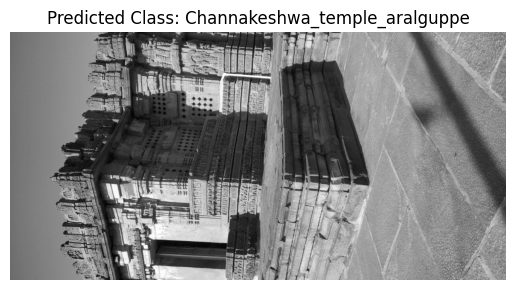

In [10]:
from PIL import Image
import matplotlib.pyplot as plt

def show_classified_image(model, support_loader, image_path, n_way, n_shot):
    # Load and transform the new image
    image = Image.open(image_path).convert('L')  # Convert to grayscale if required
    image_tensor = transform(image).unsqueeze(0).cuda()  # Add batch dimension and move to GPU

    # Get embeddings of support images and compute prototypes
    support_data, support_labels = next(iter(support_loader))
    support_data = support_data.cuda()
    support_embeddings = model(support_data)
    prototypes = support_embeddings.view(n_way, n_shot, -1).mean(dim=1)

    # Get embedding of query image (new image)
    query_embedding = model(image_tensor)

    # Compute distances to prototypes
    distances = torch.cdist(query_embedding, prototypes)
    _, predicted_label = torch.min(distances, dim=1)

    # Map label index back to class name
    predicted_class = dataset.classes[predicted_label.item()]

    # Display the image with its predicted class label
    plt.imshow(image, cmap='gray')
    plt.title(f"Predicted Class: {predicted_class}")
    plt.axis('off')
    plt.show()

# Example usage for a new image
image_path = '/content/drive/MyDrive/Challenge dataset new/Challenge dataset new/Channakeshwa_temple_aralguppe/IMG_20190316_080751.jpgresize.jpg'  # Replace with the actual path to your image
show_classified_image(model, support_loader, image_path, n_way=5, n_shot=5)

In [11]:
import time

def evaluate_model_with_timing(model, dataset, n_way, n_shot, n_query):
    support_loader, query_loader = get_dataloaders(dataset, n_way, n_shot, n_query)
    model.eval()  # Set to evaluation mode

    start_time = time.time()  # Record start time

    with torch.no_grad():  # No gradients needed for evaluation
        loss, accuracy = prototypical_loss(model, support_loader, query_loader, n_way, n_shot)

    end_time = time.time()  # Record end time
    inference_time = end_time - start_time

    print(f"Test Loss: {loss.item()}, Test Accuracy: {accuracy*100:.2f}%")
    print(f"Inference Time: {inference_time:.4f} seconds")
    return accuracy, inference_time

# Example usage on the test dataset
test_accuracy, inference_time = evaluate_model_with_timing(model, dataset, n_way=5, n_shot=5, n_query=15)

Test Loss: 0.07093355059623718, Test Accuracy: 97.33%
Inference Time: 1.2435 seconds


In [12]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.9/906.9 kB 48.4 MB/s eta 0:00:00


In [13]:
import time
import torch
from thop import profile  # For calculating GFLOPs and parameters


# Example model (replace with your actual model)
from torchvision.models import resnet18  # You can replace this with your custom model

# Define the model (replace with your model)
model = resnet18(pretrained=False)

# Define input size (batch_size, channels, height, width)
input_size = (1, 3, 28, 28)  # Example: for 28x28 image, adjust as per your data

# 1. Inference Time Calculation
def measure_inference_time(model, input_size, device='cpu'):
    model.eval()  # Set the model to evaluation mode
    inputs = torch.randn(input_size).to(device)

    if device == 'cuda':
        start = torch.cuda.Event(enable_timing=True)
        end = torch.cuda.Event(enable_timing=True)
        start.record()

        with torch.no_grad():
            _ = model(inputs)

        end.record()
        torch.cuda.synchronize()  # Wait for the events to complete
        elapsed_time_ms = start.elapsed_time(end)  # Time in milliseconds
    else:
        start_time = time.time()

        with torch.no_grad():
            _ = model(inputs)

        elapsed_time_ms = (time.time() - start_time) * 1000  # Convert to milliseconds

    print(f"Inference Time: {elapsed_time_ms:.2f} ms")

# 2. GFLOPs and Parameter Calculation
def calculate_flops_params(model, input_size, device='cpu'):
    inputs = torch.randn(input_size).to(device)  # Move inputs to the correct device
    model = model.to(device)  # Ensure model is on the correct device

    flops, params = profile(model, inputs=(inputs,))
    print(f"GFLOPs: {flops / 1e9:.2f}")  # Convert flops to GFLOPs
    print(f"Number of Parameters: {params / 1e6:.2f} M")  # Convert params to millions


# Main Execution
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # Check if GPU is available
model = model.to(device)  # Move model to the correct device

# Measure inference time
measure_inference_time(model, input_size, device=device)

# Calculate GFLOPs and Parameters
calculate_flops_params(model, input_size, device=device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Inference Time: 153.10 ms
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
GFLOPs: 0.03
Number of Parameters: 11.69 M


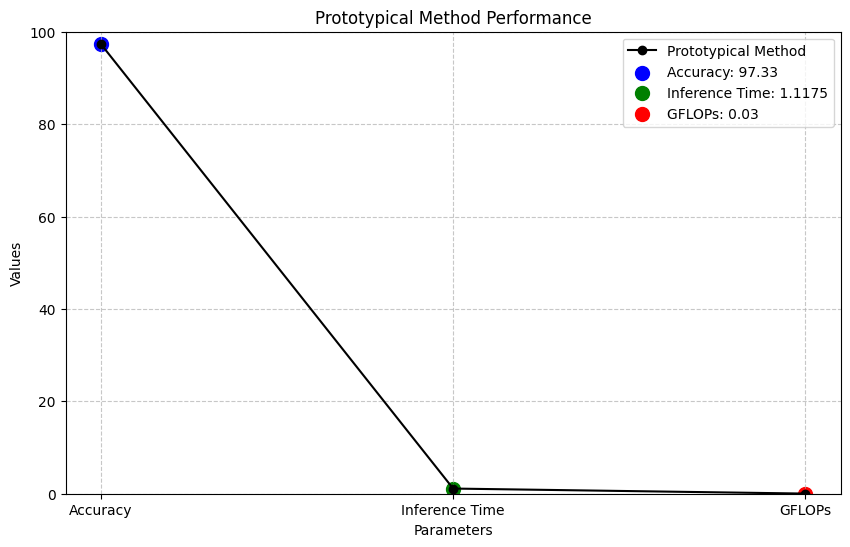

In [14]:
import matplotlib.pyplot as plt

# Data for the Prototypical Method
parameters = ["Accuracy", "Inference Time", "GFLOPs"]
values = [97.33, 1.1175, 0.03]
colors = ['blue', 'green', 'red']

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(parameters, values, marker='o', linestyle='-', color='black', label='Prototypical Method')

# Adding scatter points with individual colors and larger size
for i, (param, value, color) in enumerate(zip(parameters, values, colors)):
    plt.scatter(param, value, color=color, s=100, label=f'{param}: {value}')

# Graph labels and title
plt.xlabel('Parameters')
plt.ylabel('Values')
plt.title('Prototypical Method Performance')
plt.ylim(0, 100)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()


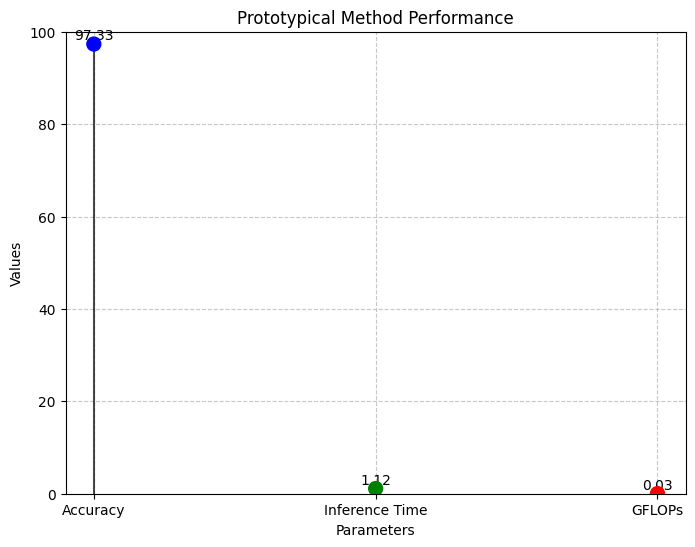

In [ ]:
import matplotlib.pyplot as plt

# Data for the Prototypical Method
parameters = ["Accuracy", "Inference Time", "GFLOPs"]
values = [97.33, 1.1175, 0.03]
colors = ['blue', 'green', 'red']

# Plotting the dot plot
plt.figure(figsize=(8, 6))
plt.scatter(parameters, values, color=colors, s=100, zorder=5)

# Adding lines to connect the dots to the y-axis
plt.vlines(parameters, 0, values, color='black', alpha=0.7)

# Adding labels and title
plt.xlabel('Parameters')
plt.ylabel('Values')
plt.title('Prototypical Method Performance')
plt.ylim(0, 100)  # Setting y-axis limit
plt.grid(True, linestyle='--', alpha=0.7)

# Adding value labels on top of the dots
for i, value in enumerate(values):
    plt.text(i, value + 1, f'{value:.2f}', ha='center', fontsize=10)

plt.show()


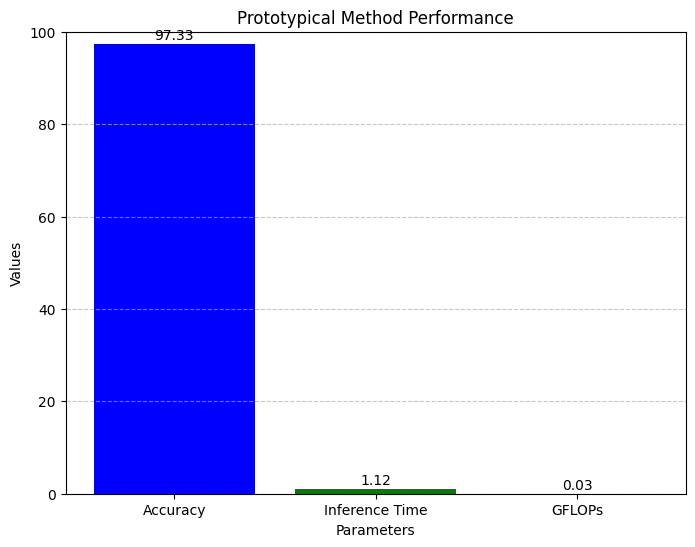

In [ ]:
import matplotlib.pyplot as plt

# Data for the Prototypical Method
parameters = ["Accuracy", "Inference Time", "GFLOPs"]
values = [97.33, 1.1175, 0.03]
colors = ['blue', 'green', 'red']

# Plotting the bar chart
plt.figure(figsize=(8, 6))
plt.bar(parameters, values, color=colors)

# Adding labels and title
plt.xlabel('Parameters')
plt.ylabel('Values')
plt.title('Prototypical Method Performance')
plt.ylim(0, 100)  # Setting y-axis limit for better comparison
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding values on top of bars
for i, value in enumerate(values):
    plt.text(i, value + 1, f'{value:.2f}', ha='center', fontsize=10)

plt.show()
